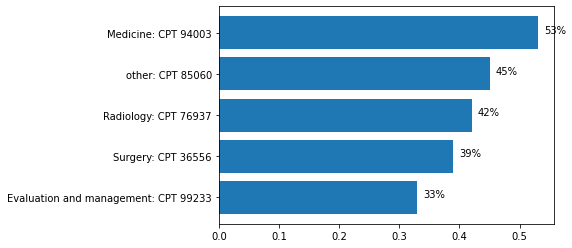

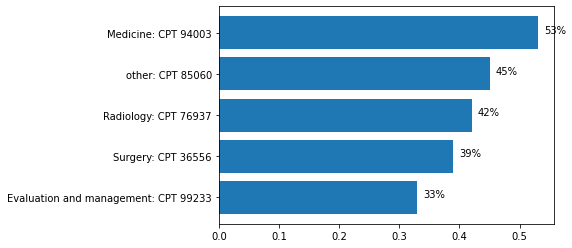

In [2]:
# -------------------------
    # Import Packages
 # -------------------------

import altair as alt
import streamlit as st
import pandas as pd
import glob
import pickle
import random
import numpy as np
import gzip
import matplotlib.pyplot as plt

 # -------------------------
    # Load from Files
 # -------------------------

def load_files():

    # Create dictionaries for models + vectorizers and lists for validation DataFrames
    models = {}
    vectorizers = {}
    X_vals = []
    Y_vals = []

    # Load paths (streamlit doesn't work with relative paths)
    model_paths = glob.glob('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\finalized_model*')
    vectorizer_paths = glob.glob('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\finalized_vectorizer*')
    X_val_paths = glob.glob('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\X_val*')
    y_val_paths = glob.glob('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\y_val*')

    # Load models
    for path in model_paths:
        nm = path.split('_')[-1].split('.')[0]
        models[nm] = pickle.load(open(path, 'rb'))

    # Load Vectorizers
    for path in vectorizer_paths:
        nm = path.split('_')[-1].split('.')[0]
        vectorizers[nm] = pickle.load(open(path, 'rb'))

    # Load X_Val Paths + Put in DataFrame
    for path in X_val_paths:
        nm = path.split('_')[-1].split('.')[0]
        df = pd.read_csv(path, index_col = 0)
        df['Section'] = nm
        X_vals.append(df)

    # Load Y_Val Paths + Put in DataFrame
    for path in y_val_paths:
        nm = path.split('_')[-1].split('.')[0]
        df = pd.read_csv(path, index_col = 0)
        df['Section'] = nm
        Y_vals.append(df)

    # Combine X_val + Y_val DataFrames
    X_vals_df = pd.concat(X_vals)
    X_vals_df.columns = ['TEXT', 'Section_drop']
    X_vals_df = X_vals_df.reset_index(drop=True)
    Y_vals_df = pd.concat(Y_vals)
    Y_vals_df = Y_vals_df.reset_index(drop=True)
    val_df = pd.concat([X_vals_df, Y_vals_df], axis=1)
    val_df.drop('Section_drop', axis=1, inplace=True)

    # Load ICD Descriptions
    with gzip.open('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\MIMIC Files\\D_ICD_DIAGNOSES.csv.gz', mode='r') as file:
        diagnosis_dsc = pd.read_csv(file)

    # Load Features
    features_df = pd.read_csv('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\features_df.csv', index_col = 0)

    return val_df, diagnosis_dsc, features_df, vectorizers, models

# -------------------------
    # Clean Text -- NEED TO ADD TO SECTION
# -------------------------

# -------------------------
    # Make Predictions
# -------------------------

def make_predictions(df, diagnosis_dsc, vectorizers, models, section='icd', other_text=[]):
    
    #Subset the DataFrame
    df = df[df['Section'] == section].reset_index()
    
    # Choose a random row
    # random.seed(30)
    row = round(random.random() * (len(df) - 1))

    # Make list for storing tuples of the code, prediction confidence, and type (CPT or ICD)
    ls = []

    # Load text data
    if len(other_text) > 0:
        input_text_clean = other_text
    else:
        input_text_clean = df.loc[row, 'TEXT']
    
    # Load Vectorizers + transform data
    for key, vectorizer in vectorizers.items():
        vectorizer_txt = vectorizer.transform([input_text_clean])

        # Load corresponding model and make prediction
        prediction = models[key].predict(vectorizer_txt)[0]
#         confidence_prob = str(round(max(models[key].predict_proba(vectorizer_txt)[0]) * 100\
#                                  ,2)
#                              ) + '%'
        confidence_prob = round(max(models[key].predict_proba(vectorizer_txt)[0]),2)
        ls.append((confidence_prob, prediction, key))

    # Create DataFrame
    predict_df = pd.DataFrame(ls)
    predict_df.columns = ['conf_prob', 'code', 'section']
    
    # ICD 9 CODE
    if np.isnan(df.loc[row, 'CPT_CD']):
        predict_df['ICD9_CODE'] = df.loc[row, 'ICD9_CODE']
    
    # CPT CODE
    else:
        predict_df['CPT_CD'] = df.loc[row, 'CPT_CD']

    # Add Additional Columns
    predict_df['OG section'] = df.loc[row, 'Section']
    type_map = {'Evaluation and management':'CPT ', 'icd':'ICD9 ', 'Medicine':'CPT ', 'other':'CPT ','Radiology':'CPT ','Surgery':'CPT '}
    predict_df['TYPE'] = predict_df['section'].map(type_map)
    predict_df['code_updated'] = predict_df['section'] + ': ' + predict_df['TYPE'] + predict_df['code']

    predict_df = predict_df.merge(diagnosis_dsc, on = 'ICD9_CODE')

    return predict_df, input_text_clean


# -------------------------
    # Function to Show ICD Prediction
# -------------------------

def icd_pred(predict_df):
    pred_icd = predict_df[predict_df.section == 'icd']['ICD9_CODE'].values[0]
    pred_icd_prob = predict_df[predict_df.section == 'icd']['conf_prob'].values[0]

    return pred_icd, pred_icd_prob

# -------------------------
    # Plot Predictions Function
# -------------------------

def plot_pred(predict_df):
    df = predict_df[predict_df.section != 'icd']
    df = df.sort_values('conf_prob')
    fig, ax = plt.subplots()
    my_bar_plot = ax.barh(df.code_updated, df.conf_prob)
    # Taken from here: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
    for i, v in enumerate(df.conf_prob):
        ax.text(v + .01, i, str(round((v * 100))) + '%')
    return fig

# -------------------------
    # Plot Features Function
# -------------------------
def plot_features(predict_df, features_df, type):
    df = predict_df.merge(features_df, left_on = ['section', 'code'], right_on = ['Section', 'Class'])\
                   .sort_values(['Class', 'Prob'], ascending=False)

    df_top = df[df.Direction == 'Top']

    if type == 'icd':
        st.write(pd.DataFrame(df_top[df_top.Section == 'icd'].head(10)
                                                             .reset_index(drop=True)
                                                             .loc[:, ['Features', 'Prob']]))
    else:
        for section in set(df_top.Section).difference({'icd'}):
            st.write('### ', section)
            st.write(pd.DataFrame(df_top[df_top.Section == section].head(10)\
                                                                   .reset_index(drop=True)\
                                                                   .loc[:, ['Features', 'Prob']]))

# -------------------------
    # Build App Run Function
# -------------------------

def run_app(val_df, diagnosis_dsc, radio_run_option, vectorizers, models, txt):
    if radio_run_option == 'Generated Text':
        
        # Set txt to empty
        txt = []

        # Call Function to Write DataFrame
        predict_df, input_text_clean = make_predictions(val_df, diagnosis_dsc,  vectorizers, models, 'icd', txt) 
        
        # ICD Prediction
        pred_icd, pred_icd_prob = icd_pred(predict_df)

    else:

        # Call Function
        predict_df, input_text_clean = make_predictions(val_df, diagnosis_dsc,  vectorizers, models, 'icd', txt) 

        # ICD Prediction
        pred_icd, pred_icd_prob = icd_pred(predict_df)

    return input_text_clean, pred_icd, pred_icd_prob, predict_df

# -------------------------
    # Initial Setup
# -------------------------

def initial_setup(radio_run_option):
    # Run initial setup
    val_df, diagnosis_dsc, features_df, vectorizers, models = load_files()

    # Run predictions
    input_text_clean, pred_icd, pred_icd_prob, predict_df = run_app(val_df, diagnosis_dsc, radio_run_option, vectorizers, models, [])

    return val_df, diagnosis_dsc, features_df, vectorizers, models, input_text_clean, pred_icd, pred_icd_prob, predict_df

# -------------------------
    # Build Streamlit App
# -------------------------

# Set variables
val_df, diagnosis_dsc, features_df, vectorizers, models, input_text_clean, pred_icd, pred_icd_prob, predict_df = initial_setup('Generated Text')

plot_pred(predict_df)


In [3]:
predict_df

    df = predict_df[predict_df.section != 'icd']
    df = df.sort_values('conf_prob')
    fig, ax = plt.subplots()
    my_bar_plot = ax.barh(df.code_updated, df.conf_prob)
    # Taken from here: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
    for i, v in enumerate(df.conf_prob):
        ax.text(v + .01, i, str(round((v * 100))) + '%')
    return fig


,conf_prob,code,section,ICD9_CODE,OG section,TYPE,code_updated,ROW_ID,SHORT_TITLE,LONG_TITLE
0,0.33,99233,Evaluation and management,41401,icd,CPT,Evaluation and management: CPT 99233,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
1,0.42,41071,icd,41401,icd,ICD9,icd: ICD9 41071,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
2,0.53,94003,Medicine,41401,icd,CPT,Medicine: CPT 94003,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
3,0.45,85060,other,41401,icd,CPT,other: CPT 85060,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
4,0.42,76937,Radiology,41401,icd,CPT,Radiology: CPT 76937,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
5,0.39,36556,Surgery,41401,icd,CPT,Surgery: CPT 36556,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...


In [72]:
# Taken from: https://documentation.uts.nlm.nih.gov/rest/source-asserted-identifiers/crosswalk/index.html

# Create Authentication Class
import requests
import lxml.html as lh
from lxml.html import fromstring

uri="https://utslogin.nlm.nih.gov"
auth_endpoint = "/cas/v1/api-key"

class Authentication:

    def __init__(self, apikey):
        self.apikey=apikey
        self.service="http://umlsks.nlm.nih.gov"

    def gettgt(self):
        params = {'apikey': self.apikey}
        h = {"Content-type": "application/x-www-form-urlencoded", "Accept": "text/plain", "User-Agent":"python" }
        r = requests.post(uri+auth_endpoint,data=params,headers=h)
        response = fromstring(r.text)
        tgt = response.xpath('//form/@action')[0]
        return tgt

    def getst(self,tgt):

        params = {'service': self.service}
        h = {"Content-type": "application/x-www-form-urlencoded", "Accept": "text/plain", "User-Agent":"python" }
        r = requests.post(tgt,data=params,headers=h)
        st = r.text
        return st

In [90]:
# Get a ticket-granting ticket
auth = Authentication('ecf1a8f1-da25-492c-8a18-b8c16faf8c72')
x = auth.gettgt()

In [129]:
# CPT Code
import json


def search_code(df):
    
    # Create list for CPT descriptions and crosswalk
    dsc_ls = []
    snomed_ls = []
    
    # Set URI 
    base_uri = 'https://uts-ws.nlm.nih.gov/rest'
    crosswalk = '/crosswalk/current/source/CPT/'
    search = '/search/2008AA'
    
    # Loop through all codes
    for i in list(df['code']):
        code = str(i)
    
        # Run search
        query = {'ticket': auth.getst(x), 'string':code, 'sabs':'CPT', 'inputType':'code', 'searchType':'exact'}
        r = requests.get(base_uri + search, params=query)
        items = json.loads(r.text)
        try:
            dsc = items['result']['results'][0]['name']
            if dsc == 'NO RESULTS':
                dsc = 'No Description Available'
        except:
            dsc = 'No Description Available'
        
        # Append to list
        dsc_ls.append(dsc)
        
        # Run crosswalk search for SNOMED-CT
        query = {'ticket': auth.getst(x), 'targetSource':'SNOMEDCT_US'}
        r = requests.get(base_uri + crosswalk + code, params=query)
        items = json.loads(r.text)
        try:
            snomed_code = items['result'][0]['ui']
        except:
            snomed_code = 'No SNOMED-CT Code Available'
            
        # Append to list
        snomed_ls.append(snomed_code)
    
    # Add to dataframe
    df['CPT_DSC'] = dsc_ls
    df['SNOMED_CT'] = snomed_ls
    
    return df
    
    


In [130]:
check = search_code(predict_df)
check

,conf_prob,code,section,ICD9_CODE,OG section,TYPE,code_updated,ROW_ID,SHORT_TITLE,LONG_TITLE,CPT_DSC,SNOMED_CT
0,0.33,99233,Evaluation and management,41401,icd,CPT,Evaluation and management: CPT 99233,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,"Subsequent hospital care, per day, for the eva...",
1,0.42,41071,icd,41401,icd,ICD9,icd: ICD9 41071,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,No Description Available,
2,0.53,94003,Medicine,41401,icd,CPT,Medicine: CPT 94003,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,"Ventilation assist and management, initiation ...",
3,0.45,85060,other,41401,icd,CPT,other: CPT 85060,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,"Blood smear, peripheral, interpretation by phy...",14768001
4,0.42,76937,Radiology,41401,icd,CPT,Radiology: CPT 76937,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,Ultrasound guidance for vascular access requir...,
5,0.39,36556,Surgery,41401,icd,CPT,Surgery: CPT 36556,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,Insertion of non-tunneled centrally inserted c...,


In [117]:
predict_df

,conf_prob,code,section,ICD9_CODE,OG section,TYPE,code_updated,ROW_ID,SHORT_TITLE,LONG_TITLE,CPT_DSC
0,0.33,99233,Evaluation and management,41401,icd,CPT,Evaluation and management: CPT 99233,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,"Subsequent hospital care, per day, for the eva..."
1,0.42,41071,icd,41401,icd,ICD9,icd: ICD9 41071,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,No Description Available
2,0.53,94003,Medicine,41401,icd,CPT,Medicine: CPT 94003,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,"Ventilation assist and management, initiation ..."
3,0.45,85060,other,41401,icd,CPT,other: CPT 85060,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,"Blood smear, peripheral, interpretation by phy..."
4,0.42,76937,Radiology,41401,icd,CPT,Radiology: CPT 76937,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,Ultrasound guidance for vascular access requir...
5,0.39,36556,Surgery,41401,icd,CPT,Surgery: CPT 36556,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,Insertion of non-tunneled centrally inserted c...


In [125]:
result['result']

[{'classType': 'SourceAtomCluster',
  'ui': '14768001',
  'suppressible': False,
  'obsolete': False,
  'rootSource': 'SNOMEDCT_US',
  'atomCount': 3,
  'cVMemberCount': 0,
  'attributes': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/attributes',
  'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/atoms',
  'descendants': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/descendants',
  'ancestors': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/ancestors',
  'parents': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/parents',
  'children': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/children',
  'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2020AB/source/SNOMEDCT_US/14768001/relations',
  'definitions': 'NONE',
  'concepts': 'https://uts-ws.nlm.nih.gov/rest/search/2020AB?string=14768001&sabs=SNOMEDC

In [71]:
bars = alt.Chart(predict_df).mark_bar().encode(
    x = alt.X('conf_prob', axis=alt.Axis(format='%', title='Confidence Probability'))
    , y = alt.Y('code_updated', sort='-x', axis=alt.Axis(title=''))
    , tooltip = ['SHORT_TITLE']
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text(shorthand='conf_prob', format='.0%')
)

(bars + text).configure_axis(labelLimit=1000
).properties(width=500, height=300)


alt.LayerChart(...)

In [151]:
hcc = pd.read_csv('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\2014_payment_year_midyear_final_icd_mapping.csv')

In [153]:
x = predict_df.merge(hcc, left_on='ICD9_CODE', right_on='DIAGNOSIS CODE')

In [186]:
# hcc.loc[0]['DIAGNOSIS CODE']
# set(predict_df.loc[:,'ICD9_CODE'])
# x.loc[0,'HCC']
# hcc[hcc['DIAGNOSIS CODE'] == '4241']['HCC'].values[0]
'0389'[0]

'0'